In [633]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
pyoff.init_notebook_mode()
from plotly.offline import init_notebook_mode, iplot
py.offline.init_notebook_mode(connected=True) 
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from mlxtend.frequent_patterns import apriori, association_rules
import random
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [656]:
#%time sales = pd.read_csv("data/Water_System_14-19.csv")
#%time sales = pd.read_csv("data/Pump_industry_14-19.csv")
%time sales = pd.read_csv("data/wholesale_14-19.csv")


Wall time: 7.25 s


In [657]:
sales=sales.sort_values(by=['Date'])

sales=sales.drop(['Column 32'], axis=1)
sales=sales.drop(['MonthYear'], axis=1)
sales_copy=sales

In [769]:
sales.head(2)
sales.columns

Index(['Date', 'OrderNumber', 'OrderLineNumber', 'Quantity', 'SellPrice',
       'CCN', 'PartnerNumber', 'Material', 'ItemCategoryGroup', 'ItemCategory',
       'ItemDescription', 'ProductCode', 'ProductDescription',
       'NounCodeDescription', 'NounCode', 'ShipFrom', 'CustomerName', 'CustId',
       'City', 'State', 'PostalCode', 'Country', 'Region', 'SubRegion',
       'Industry', 'IndustryGroup', 'Plant', 'PlantType', 'PlantPlatform',
       'Market'],
      dtype='object')

### Associations within and across various part product families and customers

In [770]:
# Let's  find out the association between items, so we can offer items in case one of the item was ordered, or offer bundles

In [771]:
#let's check how many orders we have
sales['OrderNumber'].unique

<bound method Series.unique of 0          order_number_194969
1733       order_number_143439
1734       order_number_143439
1735       order_number_143439
1736       order_number_143439
                  ...         
1691707    order_number_176310
1691706    order_number_176310
1691705    order_number_176310
1691703    order_number_176310
1691605    order_number_176310
Name: OrderNumber, Length: 1817745, dtype: object>

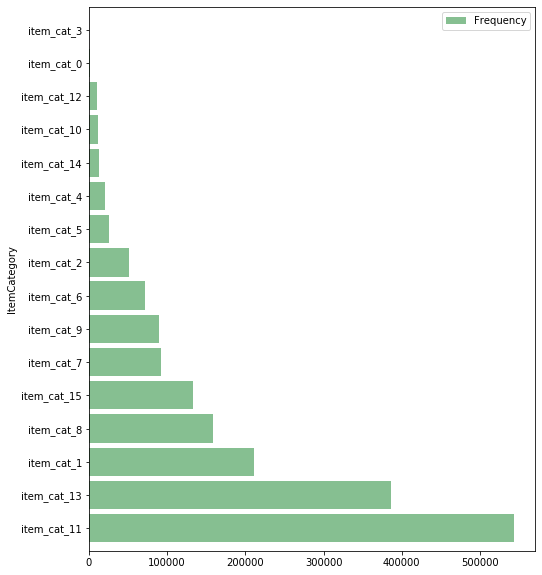

In [772]:
#frequencies of ItemDescription

fs_freq_item=sales.groupby(['ItemCategory']).size().reset_index(name='Frequency')
fs_freq_item=fs_freq_item.sort_values(by=['Frequency'], ascending =[False])
a=fs_freq_item.head(20)
ax = a.plot(kind='barh', x='ItemCategory', y='Frequency',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

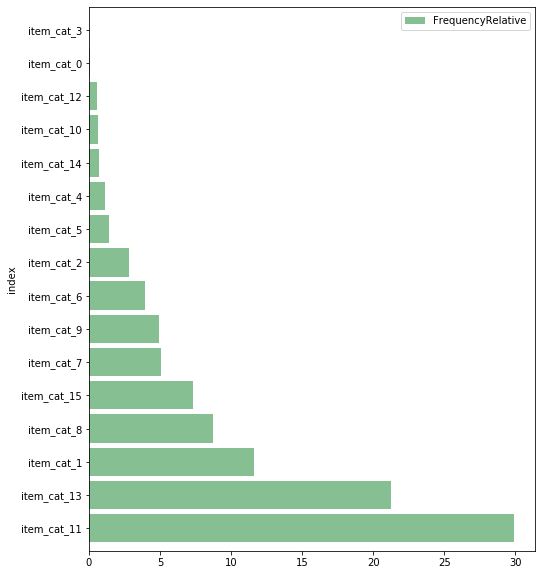

In [773]:
# relative frequencies of ItemDescription

a=sales['ItemCategory'].value_counts(True).reset_index(name='FrequencyRelative')
a['FrequencyRelative']=a['FrequencyRelative']*100
b=a.sort_values(by=['FrequencyRelative'], ascending =[False])
ab=b.head(20)
ax = ab.plot(kind='barh', x='index', y='FrequencyRelative',figsize=(8, 10), color='#86bf91', zorder=2,width=0.85)

In [774]:
#get table with counts per ItemDescription each row is order number and colimns is count of items fot that order
fs_ON = (sales.groupby(['OrderNumber', 'ItemCategory'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('OrderNumber')) 
fs_ON.head(5)

ItemCategory         item_cat_0  item_cat_1  item_cat_10  item_cat_11  \
OrderNumber                                                             
order_number_10001          0.0         2.0          0.0          0.0   
order_number_100014         0.0         0.0          0.0          6.0   
order_number_100023         0.0         8.0          0.0          0.0   
order_number_100034         0.0        12.0          0.0         36.0   
order_number_100036         0.0         6.0          0.0          6.0   

ItemCategory         item_cat_12  item_cat_13  item_cat_14  item_cat_15  \
OrderNumber                                                               
order_number_10001           0.0          0.0          0.0          0.0   
order_number_100014          0.0          0.0          0.0          0.0   
order_number_100023          0.0          0.0          0.0          0.0   
order_number_100034          0.0          0.0          0.0         36.0   
order_number_100036          0.0          0.0          0.0          0.0   

ItemCategory         item_cat_2  item_cat_3  item_cat_4  item_cat_5  \
OrderNumber                                                           
order_number_10001          0.0         0.0         0.0         0.0   
order_number_100014         0.0         0.0         0.0         0.0   
order_number_100023         8.0         0.0         0.0         8.0   
order_number_100034         0.0         0.0         0.0         0.0   
order_number_100036         0.0         0.0         0.0         0.0   

ItemCategory         item_cat_6  item_cat_7  item_cat_8  item_cat_9  
OrderNumber                                                          
order_number_10001          0.0         0.0         0.0         0.0  
order_number_100014         0.0         0.0         0.0         0.0  
order_number_100023         8.0         0.0         8.0         0.0  
order_number_100034         0.0        12.0        24.0        12.0  
order_number_100036         0.0         6.0         6.0         0.0

In [775]:
# function to convert cound to 1 or 0
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [776]:
# Encoding the datasets 
fs_ON_encoded = fs_ON.applymap(hot_encode) 
fs_ON = fs_ON_encoded 
fs_ON.head(5)

ItemCategory         item_cat_0  item_cat_1  item_cat_10  item_cat_11  \
OrderNumber                                                             
order_number_10001            0           1            0            0   
order_number_100014           0           0            0            1   
order_number_100023           0           1            0            0   
order_number_100034           0           1            0            1   
order_number_100036           0           1            0            1   

ItemCategory         item_cat_12  item_cat_13  item_cat_14  item_cat_15  \
OrderNumber                                                               
order_number_10001             0            0            0            0   
order_number_100014            0            0            0            0   
order_number_100023            0            0            0            0   
order_number_100034            0            0            0            1   
order_number_100036            0            0            0            0   

ItemCategory         item_cat_2  item_cat_3  item_cat_4  item_cat_5  \
OrderNumber                                                           
order_number_10001            0           0           0           0   
order_number_100014           0           0           0           0   
order_number_100023           1           0           0           1   
order_number_100034           0           0           0           0   
order_number_100036           0           0           0           0   

ItemCategory         item_cat_6  item_cat_7  item_cat_8  item_cat_9  
OrderNumber                                                          
order_number_10001            0           0           0           0  
order_number_100014           0           0           0           0  
order_number_100023           1           0           1           0  
order_number_100034           0           1           1           1  
order_number_100036           0           1           1           0

In [777]:
# create assocition with support > 0.001 using apriori algorithm
frq_items = apriori(fs_ON, min_support = 0.005, use_colnames = True)
frq_items.sort_values(by=['support'], ascending =[False]).head(10)

support                    itemsets
2   0.436135               (item_cat_11)
4   0.406070               (item_cat_13)
0   0.316865                (item_cat_1)
30  0.225525  (item_cat_11, item_cat_13)
12  0.216649                (item_cat_8)
14  0.196892   (item_cat_1, item_cat_11)
11  0.189838                (item_cat_7)
7   0.173283                (item_cat_2)
6   0.165213               (item_cat_15)
10  0.165161                (item_cat_6)

In [778]:
# create rules using "lift as a metric and thershold=1 "
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print("Rules amount : " , len(rules))
rules.head(10)

Rules amount :  10886


antecedents    consequents  \
9202   (item_cat_9, item_cat_7, item_cat_1, item_cat_...  (item_cat_11)   
8644   (item_cat_8, item_cat_9, item_cat_1, item_cat_...  (item_cat_11)   
10508  (item_cat_8, item_cat_9, item_cat_1, item_cat_...  (item_cat_11)   
10008  (item_cat_8, item_cat_9, item_cat_6, item_cat_...  (item_cat_11)   
10760  (item_cat_8, item_cat_9, item_cat_7, item_cat_...  (item_cat_11)   
9450   (item_cat_8, item_cat_9, item_cat_7, item_cat_...  (item_cat_11)   
10634  (item_cat_8, item_cat_9, item_cat_7, item_cat_...  (item_cat_11)   
9264   (item_cat_8, item_cat_9, item_cat_1, item_cat_...  (item_cat_11)   
7232   (item_cat_15, item_cat_8, item_cat_9, item_cat_6)  (item_cat_11)   
9326   (item_cat_8, item_cat_9, item_cat_7, item_cat_...  (item_cat_11)   

       antecedent support  consequent support   support  confidence      lift  \
9202             0.005128            0.436135  0.005102    0.994924  2.281229   
8644             0.007262            0.436135  0.007158    0.985663  2.259995   
10508            0.006586            0.436135  0.006482    0.984190  2.256617   
10008            0.007419            0.436135  0.007288    0.982456  2.252642   
10760            0.005883            0.436135  0.005753    0.977876  2.242141   
9450             0.006508            0.436135  0.006351    0.976000  2.237839   
10634            0.007445            0.436135  0.007262    0.975524  2.236749   
9264             0.007184            0.436135  0.007002    0.974638  2.234715   
7232             0.008408            0.436135  0.008173    0.972136  2.228980   
9326             0.008278            0.436135  0.008043    0.971698  2.227975   

       leverage  conviction  
9202   0.002865  111.081396  
8644   0.003991   39.329581  
10508  0.003609   35.664458  
10008  0.004053   32.140302  
10760  0.003187   25.486696  
9450   0.003513   23.494373  
10634  0.004016   23.037911  
9264   0.003869   22.232390  
7232   0.004507   20.236487  
9326   0.004433   19.923228

In [779]:
# fumction to plot the rules :

def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
    plt.figure(1,figsize=(15,10))
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R1', 'R2',  'R3', 'R4', 'R5','R6', 'R7', 'R8', 'R9','R10']   
    
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:

            G1.add_nodes_from([a])

            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

        for c in rules.iloc[i]['consequents']:

            G1.add_nodes_from([c])

            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)            
  
            
    for node in G1:
        found_a_string = False

        for item in strs: 
            if node==item:
                found_a_string = True

        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green') 

        
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=20, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
 
    plt.show()

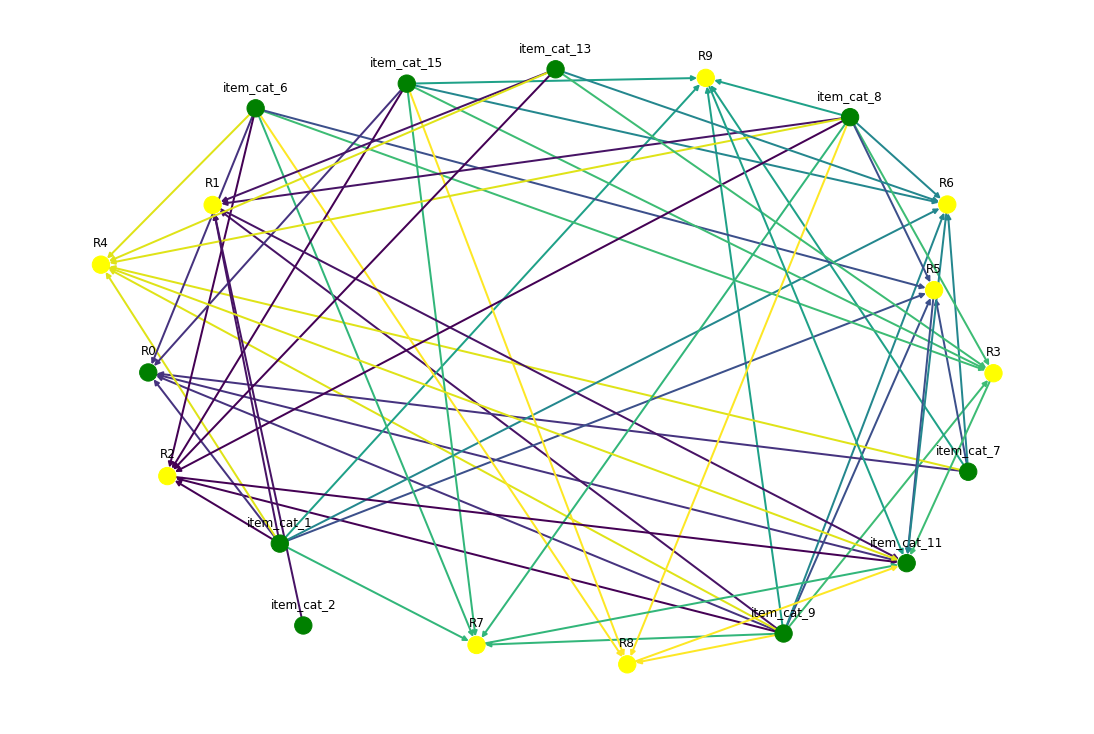

In [780]:
# Draw top 10 rules
draw_graph(rules, 10)

In [781]:
# next let find association between customers that buying the same items, so we can offer product to customer 
#with the same interset.


In [782]:
#get table with counts per ItemDescription
fs_ON_cust = (sales.groupby([ 'ItemCategory','CustId'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('ItemCategory')) 
fs_ON_cust.head(5)

CustId        cust_id_1028  cust_id_1031  cust_id_1033  cust_id_1051  \
ItemCategory                                                           
item_cat_0             0.0           0.0           0.0           0.0   
item_cat_1          2234.0           0.0           0.0          87.0   
item_cat_10           11.0           0.0           0.0           0.0   
item_cat_11         4883.0           0.0           0.0         267.0   
item_cat_12            3.0           0.0           0.0           2.0   

CustId        cust_id_1066  cust_id_1103  cust_id_1113  cust_id_1130  \
ItemCategory                                                           
item_cat_0             0.0           2.0           0.0         399.0   
item_cat_1             0.0         158.0         165.0        6430.0   
item_cat_10            0.0           4.0          39.0         457.0   
item_cat_11            0.0         585.0         641.0       20683.0   
item_cat_12            4.0           0.0           3.0         200.0   

CustId        cust_id_1133  cust_id_1177  ...  cust_id_876  cust_id_879  \
ItemCategory                              ...                             
item_cat_0             0.0           0.0  ...         32.0         29.0   
item_cat_1             0.0           6.0  ...      39015.0      17359.0   
item_cat_10            0.0           0.0  ...       3287.0         64.0   
item_cat_11            0.0           0.0  ...     146107.0      49912.0   
item_cat_12            0.0           0.0  ...       3953.0        943.0   

CustId        cust_id_88  cust_id_895  cust_id_904  cust_id_935  cust_id_958  \
ItemCategory                                                                   
item_cat_0           0.0          0.0          0.0          0.0          0.0   
item_cat_1           0.0          0.0          0.0         93.0          0.0   
item_cat_10          0.0          0.0          0.0          0.0          0.0   
item_cat_11          0.0          0.0          9.0        288.0          0.0   
item_cat_12          0.0          0.0          0.0          0.0          0.0   

CustId        cust_id_959  cust_id_988  cust_id_992  
ItemCategory                                         
item_cat_0            7.0          0.0          0.0  
item_cat_1         1545.0         41.0        186.0  
item_cat_10         118.0          0.0          8.0  
item_cat_11        5461.0          0.0         72.0  
item_cat_12          82.0          0.0          6.0  

[5 rows x 230 columns]

In [783]:
# Encoding the datasets 
fs_ON_cust_encoded = fs_ON_cust.applymap(hot_encode) 
fs_ON_cust = fs_ON_cust_encoded 
fs_ON_cust.head(5)

CustId        cust_id_1028  cust_id_1031  cust_id_1033  cust_id_1051  \
ItemCategory                                                           
item_cat_0               0             0             0             0   
item_cat_1               1             0             0             1   
item_cat_10              1             0             0             0   
item_cat_11              1             0             0             1   
item_cat_12              1             0             0             1   

CustId        cust_id_1066  cust_id_1103  cust_id_1113  cust_id_1130  \
ItemCategory                                                           
item_cat_0               0             1             0             1   
item_cat_1               0             1             1             1   
item_cat_10              0             1             1             1   
item_cat_11              0             1             1             1   
item_cat_12              1             0             1             1   

CustId        cust_id_1133  cust_id_1177  ...  cust_id_876  cust_id_879  \
ItemCategory                              ...                             
item_cat_0               0             0  ...            1            1   
item_cat_1               0             1  ...            1            1   
item_cat_10              0             0  ...            1            1   
item_cat_11              0             0  ...            1            1   
item_cat_12              0             0  ...            1            1   

CustId        cust_id_88  cust_id_895  cust_id_904  cust_id_935  cust_id_958  \
ItemCategory                                                                   
item_cat_0             0            0            0            0            0   
item_cat_1             0            0            0            1            0   
item_cat_10            0            0            0            0            0   
item_cat_11            0            0            1            1            0   
item_cat_12            0            0            0            0            0   

CustId        cust_id_959  cust_id_988  cust_id_992  
ItemCategory                                         
item_cat_0              1            0            0  
item_cat_1              1            1            1  
item_cat_10             1            0            1  
item_cat_11             1            0            1  
item_cat_12             1            0            1  

[5 rows x 230 columns]

In [784]:
# create assocition with support > 0.001
frq_items_cust = apriori(fs_ON_cust, min_support = 0.005, use_colnames = True)
frq_items_cust.head(10)

MemoryError: 

In [ ]:
rules_cust = association_rules(frq_items_cust, metric ="lift", min_threshold = 1) 
rules_cust = rules_cust.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_cust.head(10))
rules_cust=rules_cust.head(10)

In [ ]:
draw_graph(rules_cust, 10)

### Predict future purchases of various parts for customers

### EDA

In [33]:
#RFM calculation

#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])

#creating YearMonth field for the ease of reporting and visualization
sales['InvoiceYearMonth'] = sales['Date'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
sales['Revenue'] = sales['SellPrice'] * sales['Quantity']

fs_revenue = sales.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()

#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
plot_data = [
    go.Scatter(
        x=fs_revenue['InvoiceYearMonth'],
        y=fs_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [34]:
#Calculate monthly change in percantage (pct_change)

fs_revenue['MonthlyGrowth'] = fs_revenue['Revenue'].pct_change()*100

#visualization - line graph
plot_data = [
    go.Scatter(
        x=fs_revenue.query("InvoiceYearMonth < 201912")['InvoiceYearMonth'],
        y=fs_revenue.query("InvoiceYearMonth < 201912")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [35]:
# count customers ID's for each month
fs_monthly_active = sales.groupby('InvoiceYearMonth')['CustId'].nunique().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='CustId', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [36]:
# number of orders for each month

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Quantity', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Number of Orders'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [37]:
# average revenue for each month 

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Revenue', rot=0, figsize=(20, 6))

#plot the bar chart
plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [38]:
#create a dataframe contaning CustomerID and first purchase date

fs_min_purchase = sales.groupby('CustId').Date.min().reset_index()
fs_min_purchase.columns = ['CustId','MinPurchaseDate']
fs_min_purchase['MinPurchaseYearMonth'] = fs_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
fs_min_purchase

#merge first purchase date column to our main dataframe
sales = pd.merge(sales, fs_min_purchase, on='CustId')
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...       Plant   PlantType     PlantPlatform            Market MonthYear  \
0  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
1  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
2  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
3  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
4  ...  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   

  Column 32 InvoiceYearMonth     Revenue MinPurchaseDate MinPurchaseYearMonth  
0      2014           201401  1009.33081      2014-01-02               201401  
1      2014           201401    55.99986      2014-01-02               201401  
2      2014           201401  1847.99538      2014-01-02               201401  
3      2014           201401   459.99885      2014-01-02               201401  
4      2014           201401    33.33325      2014-01-02               201401  

[5 rows x 36 columns]

In [39]:
#create a column called User Type and assign New or Existing 

sales['UserType'] = 'New'
sales.loc[sales['InvoiceYearMonth']>sales['MinPurchaseYearMonth'],'UserType'] = 'Existing'
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...   PlantType     PlantPlatform            Market MonthYear Column 32  \
0  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
1  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
2  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
3  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   
4  ...  Unassigned  plant_platform_1  General Industry   01/2014      2014   

  InvoiceYearMonth     Revenue MinPurchaseDate MinPurchaseYearMonth UserType  
0           201401  1009.33081      2014-01-02               201401      New  
1           201401    55.99986      2014-01-02               201401      New  
2           201401  1847.99538      2014-01-02               201401      New  
3           201401   459.99885      2014-01-02               201401      New  
4           201401    33.33325      2014-01-02               201401      New  

[5 rows x 37 columns]

In [40]:
#calculate the Revenue per month for each user type
fs_user_type_revenue = sales.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
fs_user_type_revenue.head(5)

InvoiceYearMonth  UserType       Revenue
0            201401       New  2.008806e+07
1            201402  Existing  2.529167e+07
2            201402       New  6.707103e+05
3            201403  Existing  2.757499e+07
4            201403       New  1.426036e+05

In [46]:
plot_data = [
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
   )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [47]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)

fs_user_ratio = sales.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustId'].nunique()/sales.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustId'].nunique() 
fs_user_ratio = fs_user_ratio.reset_index()
fs_user_ratio = fs_user_ratio.dropna()

#<1 - existing more

#plot the result

plot_data = [
    go.Bar(
        x=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [49]:
#Retention calculation :
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total
#create retention matrix with crosstab
#identify which users are active by looking at their revenue per month
fs_user_purchase = sales.groupby(['CustId','InvoiceYearMonth'])['Revenue'].sum().reset_index()
fs_user_purchase

fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()

fs_retention.head(5)

InvoiceYearMonth        CustId  201401  201402  201403  201404  201405  \
0                 cust_id_1028       1       1       1       1       1   
1                 cust_id_1031       0       0       0       0       0   
2                 cust_id_1033       0       0       0       0       0   
3                 cust_id_1051       0       0       0       0       0   
4                 cust_id_1066       1       1       1       1       1   

InvoiceYearMonth  201406  201407  201408  201409  ...  201808  201809  201810  \
0                      1       0       1       1  ...       1       1       1   
1                      0       0       0       0  ...       0       0       0   
2                      0       0       0       0  ...       0       0       0   
3                      0       0       0       0  ...       0       0       0   
4                      1       1       1       1  ...       0       1       1   

InvoiceYearMonth  201811  201812  201901  201902  201903  201904  201905  
0                      1       1       1       1       1       1       1  
1                      0       0       0       0       0       0       0  
2                      0       0       0       0       0       0       0  
3                      0       0       0       0       0       0       0  
4                      0       0       1       1       1       1       0  

[5 rows x 66 columns]

In [50]:
#create an array of dictionary which keeps Retained & Total User count for each month
#customer bought in 2 consequencs months

months = fs_retention.columns[2:]
retention_array = []

for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = fs_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = fs_retention[(fs_retention[selected_month]>0) & (fs_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
fs_retention = pd.DataFrame(retention_array)
fs_retention['RetentionRate'] = fs_retention['RetainedUserCount']/fs_retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=fs_retention.query("InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_retention.query("InvoiceYearMonth<201912")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [54]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
#convert retention 0,1 to rate
#getting 1 customer ID with purchase month

fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()
#new column names
new_column_names = [ 'm_' + str(column) for column in fs_retention.columns]
fs_retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = fs_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(fs_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
        
    retention_array.append(retention_data)
    
fs_retention = pd.DataFrame(retention_array)
fs_retention.index = months

#showing new cohort based retention table
fs_retention.head(10)

TotalUserCount  201402  201403  201404  201405  201406  \
InvoiceYearMonth                                                           
201402                        61     1.0     0.8    0.74    0.74    0.70   
201403                        63     NaN     1.0    0.83    0.79    0.73   
201404                        68     NaN     NaN    1.00    0.81    0.71   
201405                        66     NaN     NaN     NaN    1.00    0.74   
201406                        63     NaN     NaN     NaN     NaN    1.00   
201407                        56     NaN     NaN     NaN     NaN     NaN   
201408                        63     NaN     NaN     NaN     NaN     NaN   
201409                        57     NaN     NaN     NaN     NaN     NaN   
201410                        66     NaN     NaN     NaN     NaN     NaN   
201411                        55     NaN     NaN     NaN     NaN     NaN   

                  201407  201408  201409  201410  ...  201808  201809  201810  \
InvoiceYearMonth                                  ...                           
201402              0.67    0.67    0.62    0.62  ...    0.39    0.39    0.39   
201403              0.70    0.68    0.62    0.62  ...    0.38    0.38    0.38   
201404              0.68    0.66    0.59    0.57  ...    0.35    0.35    0.35   
201405              0.70    0.68    0.61    0.59  ...    0.36    0.36    0.36   
201406              0.78    0.73    0.63    0.62  ...    0.38    0.38    0.38   
201407              1.00    0.89    0.77    0.75  ...    0.43    0.43    0.43   
201408               NaN    1.00    0.79    0.76  ...    0.38    0.38    0.38   
201409               NaN     NaN    1.00    0.86  ...    0.42    0.42    0.42   
201410               NaN     NaN     NaN    1.00  ...    0.36    0.36    0.36   
201411               NaN     NaN     NaN     NaN  ...    0.45    0.45    0.45   

                  201811  201812  201901  201902  201903  201904  201905  
InvoiceYearMonth                                                          
201402              0.39    0.39    0.39    0.39    0.38    0.38    0.34  
201403              0.38    0.38    0.38    0.38    0.37    0.37    0.33  
201404              0.35    0.35    0.35    0.35    0.34    0.34    0.31  
201405              0.36    0.36    0.36    0.36    0.35    0.35    0.32  
201406              0.38    0.38    0.38    0.38    0.37    0.37    0.33  
201407              0.43    0.43    0.43    0.43    0.41    0.41    0.38  
201408              0.38    0.38    0.38    0.38    0.37    0.37    0.33  
201409              0.42    0.42    0.42    0.42    0.40    0.40    0.37  
201410              0.36    0.36    0.36    0.36    0.35    0.35    0.32  
201411              0.45    0.45    0.45    0.45    0.44    0.44    0.40  

[10 rows x 65 columns]

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

In [225]:
#get the max purchase date for each customer and create a dataframe with it
fs_max_purchase = sales.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']

In [226]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
sales_cust = pd.DataFrame(sales['CustId'].unique())
sales_cust.columns = ['CustId']
print(len(sales_cust))
sales_cust.head(10)

230


CustId
0   cust_id_535
1   cust_id_876
2   cust_id_879
3  cust_id_4279
4  cust_id_1584
5  cust_id_2768
6  cust_id_2000
7  cust_id_2110
8  cust_id_2053
9  cust_id_1130

In [227]:
#take observation point as the max invoice date in our dataset
#calculate difference between max purchace and last purcahse
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_max_purchase.head(10)

CustId MaxPurchaseDate  Recency
0  cust_id_1028      2019-05-07        0
1  cust_id_1031      2018-07-20      291
2  cust_id_1033      2016-01-29     1194
3  cust_id_1051      2017-10-12      572
4  cust_id_1066      2019-04-24       13
5  cust_id_1103      2019-05-06        1
6  cust_id_1113      2019-05-07        0
7  cust_id_1130      2019-05-07        0
8  cust_id_1133      2016-08-10     1000
9  cust_id_1177      2019-02-20       76

In [228]:
fs_max_purchase_sort=fs_max_purchase.sort_values(by=['Recency'], ascending =[False])
print(len(fs_max_purchase_sort))
fs_max_purchase_sort.head(10)

230


CustId MaxPurchaseDate  Recency
180  cust_id_4124      2014-01-15     1938
19   cust_id_1387      2014-01-20     1933
93   cust_id_2605      2014-02-05     1917
18   cust_id_1369      2014-03-18     1876
165  cust_id_3858      2014-03-21     1873
226   cust_id_958      2014-03-28     1866
179  cust_id_4105      2014-04-11     1852
155  cust_id_3730      2014-05-16     1817
218    cust_id_85      2014-06-04     1798
205   cust_id_643      2014-06-16     1786

In [229]:
#merge this dataframe to our new user dataframe
fs_cust = pd.merge(sales_cust, fs_max_purchase[['CustId','Recency']], on='CustId')
print(len(fs_cust))
a=fs_max_purchase.sort_values(by=['Recency'], ascending =[False])
a.tail(150)

230


CustId MaxPurchaseDate  Recency
49   cust_id_1870      2017-07-18      658
74    cust_id_229      2017-07-21      655
212    cust_id_74      2017-07-21      655
118  cust_id_3052      2017-08-02      643
207   cust_id_656      2017-08-25      620
..            ...             ...      ...
191  cust_id_4279      2019-05-07        0
197   cust_id_470      2019-05-07        0
53   cust_id_1924      2019-05-07        0
202   cust_id_549      2019-05-07        0
0    cust_id_1028      2019-05-07        0

[150 rows x 3 columns]

In [230]:
#plot a recency histogram
# recency by blocks, 
plot_data = [
    go.Histogram(
        x=fs_cust['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [231]:
# lets try to remove the data with recency leas than 7 days

In [232]:
fs_cust_temp=fs_cust
fs_cust_temp=fs_cust_temp
fs_cust_temp.drop(fs_cust_temp.loc[fs_cust_temp['Recency']<=7].index, inplace=True)
fs_cust_temp

#plot a recency histogram
# recency by blocks, 
plot_data = [
    go.Histogram(
        x=fs_cust['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [233]:
fs_cust_temp.Recency.describe()

count     179.000000
mean      658.608939
std       597.889465
min         8.000000
25%        76.000000
50%       509.000000
75%      1116.000000
max      1938.000000
Name: Recency, dtype: float64

In [234]:
fs_cust=fs_cust_temp

In [235]:
fs_cust.Recency.describe()

count     179.000000
mean      658.608939
std       597.889465
min         8.000000
25%        76.000000
50%       509.000000
75%      1116.000000
max      1938.000000
Name: Recency, dtype: float64

In [236]:
# let create cluster based on Recency

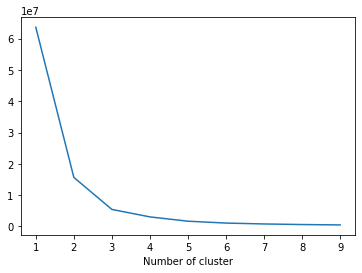

In [237]:
# criteria - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [238]:
#optimum number is 3
n_clusters=3

In [239]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])
fs_cust

CustId  Recency  RecencyCluster
0     cust_id_535      350               1
8    cust_id_2053       76               1
12   cust_id_1845       43               1
16   cust_id_1700       15               1
17   cust_id_1066       13               1
..            ...      ...             ...
225  cust_id_3846     1649               2
226  cust_id_3692      907               0
227   cust_id_455      168               1
228  cust_id_1301      872               0
229  cust_id_3728     1589               2

[179 rows x 3 columns]

In [240]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust

CustId  Recency  RecencyCluster
0     cust_id_535      350               2
1    cust_id_2053       76               2
2    cust_id_1845       43               2
3    cust_id_1700       15               2
4    cust_id_1066       13               2
..            ...      ...             ...
174  cust_id_2168     1708               0
175  cust_id_2089     1693               0
176  cust_id_1881     1688               0
177  cust_id_3846     1649               0
178  cust_id_3728     1589               0

[179 rows x 3 columns]

In [241]:
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count         mean         std     min      25%     50%  \
RecencyCluster                                                            
0                33.0  1644.606061  195.923604  1275.0  1484.00  1677.0   
1                56.0   891.464286  203.182584   539.0   735.25   843.5   
2                90.0   152.188889  147.292028     8.0    35.25    76.0   

                    75%     max  
RecencyCluster                   
0               1798.00  1938.0  
1               1096.50  1236.0  
2                265.75   509.0

In [242]:
# next adding Frequency

In [243]:
# Frequency clustering

#get order counts for each user and create a dataframe with it
fs_frequency = sales.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']

In [244]:
#add this data to our main dataframe
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')
fs_cust.head(5)
fs_cust.sort_values(by=['Frequency'], ascending =[False])
len(fs_cust)

179

In [245]:
# delete frequency =1
fs_cust_temp_freq=fs_cust
fs_cust_temp_freq.drop(fs_cust_temp_freq.loc[fs_cust_temp_freq['Frequency']==1].index, inplace=True)
fs_cust_temp_freq.tail()

CustId  Recency  RecencyCluster  Frequency
171  cust_id_3547     1397               0         81
173   cust_id_125     1677               0          2
174  cust_id_2168     1708               0         64
175  cust_id_2089     1693               0         36
176  cust_id_1881     1688               0          4

In [257]:
fs_cust=fs_cust_temp_freq
len(fs_cust)

151

In [258]:
#k-means
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

#order the frequency cluster
fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)

#see details of each cluster
fs_cust.groupby('FrequencyCluster')['Frequency'].describe()

count          mean          std      min      25%      50%  \
FrequencyCluster                                                                
0                 140.0    417.528571   920.385128      2.0     10.0     70.0   
1                   7.0  12871.428571  4180.192334   9272.0  10303.5  11505.0   
2                   4.0  38615.250000  7721.441980  33636.0  33706.5  35446.0   

                       75%      max  
FrequencyCluster                     
0                   247.50   5463.0  
1                 13639.00  21438.0  
2                 40354.75  49933.0

In [259]:
#dropping customer, think outliers
# sales.drop(sales.loc[sales['CustId']=='cust_id_576'].index, inplace=True)
# sales.drop(sales.loc[sales['CustId']=='cust_id_1653'].index, inplace=True)
# sales.shape

In [260]:
fs_cust_sort=fs_cust.sort_values(by=['Frequency'], ascending =[False])
fs_cust_sort.head
len(fs_cust_sort)
fs_cust_sort.head(30)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
9    cust_id_1700       15               2      49933                 2
10   cust_id_1621      145               2      37162                 2
8    cust_id_1845       43               2      33730                 2
7    cust_id_2053       76               2      33636                 2
4     cust_id_817       22               2      21438                 1
6    cust_id_1792       20               2      13972                 1
0     cust_id_535      350               2      13306                 1
1    cust_id_3919       14               2      11505                 1
2    cust_id_2352       13               2      11315                 1
3    cust_id_2132       39               2       9292                 1
5    cust_id_1619       48               2       9272                 1
14   cust_id_2822       27               2       5463                 0
17   cust_id_2980       53               2       4303                 0
36   cust_id_2082       56               2       3944                 0
13   cust_id_2280        8               2       3819                 0
24   cust_id_3601       19               2       3253                 0
21    cust_id_496      243               2       2943                 0
106  cust_id_3737      696               1       2878                 0
64   cust_id_3291      428               2       2704                 0
30   cust_id_2725       21               2       2664                 0
94    cust_id_542      539               1       1844                 0
37   cust_id_3162      116               2       1706                 0
43   cust_id_2234      110               2       1562                 0
142  cust_id_4008     1336               0       1380                 0
82   cust_id_3603      721               1       1124                 0
22   cust_id_3799       34               2       1073                 0
42   cust_id_3558       29               2        978                 0
139  cust_id_3214     1393               0        947                 0
29   cust_id_3932       40               2        900                 0
49   cust_id_2701       22               2        891                 0

In [261]:
# one customer has 211573 orders, that drives the cluster to 1 data point.
# lets try to delete it cust_id_576

In [262]:
# fs_cust_test=fs_cust
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_3827'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_1697'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_2585'].index, inplace=True)


# #fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_576'].index, inplace=True)
# fs_cust_test

# #k-means
# kmeans = KMeans(n_clusters)
# kmeans.fit(fs_cust_test[['Frequency']])
# fs_cust_test['FrequencyCluster'] = kmeans.predict(fs_cust_test[['Frequency']])

# #order the frequency cluster
# fs_cust_test = order_cluster('FrequencyCluster', 'Frequency',fs_cust_test,True)

# #see details of each cluster
# fs_cust_test.groupby('FrequencyCluster')['Frequency'].describe()

In [263]:
# # looks better w/o cust_id_576 
# # Ill proceed w/o it
# fs_cust=fs_cust_test

In [264]:
# Revenue Clustering

#calculate revenue for each customer
fs_revenue = sales.groupby('CustId').Revenue.sum().reset_index()

#merge it with our main dataframe
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
fs_cust.head(5)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535      350               2      13306                 1   
1  cust_id_3919       14               2      11505                 1   
2  cust_id_2352       13               2      11315                 1   
3  cust_id_2132       39               2       9292                 1   
4   cust_id_817       22               2      21438                 1   

        Revenue  
0  9.649215e+06  
1  1.104257e+07  
2  2.986748e+07  
3  8.045416e+06  
4  8.555188e+06

In [266]:
fs_cust.sort_values(by=['Revenue'], ascending =[False])

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
10   cust_id_1621      145               2      37162                 2   
5    cust_id_1619       48               2       9272                 1   
7    cust_id_2053       76               2      33636                 2   
2    cust_id_2352       13               2      11315                 1   
9    cust_id_1700       15               2      49933                 2   
..            ...      ...             ...        ...               ...   
89   cust_id_4310     1215               1          2                 0   
150  cust_id_1881     1688               0          4                 0   
78   cust_id_3826      265               2          8                 0   
47   cust_id_3740      461               2          2                 0   
104  cust_id_3560     1181               1          4                 0   

          Revenue  
10   1.161112e+08  
5    3.859919e+07  
7    3.039242e+07  
2    2.986748e+07  
9    2.775084e+07  
..            ...  
89   6.613317e+02  
150  4.799988e+02  
78   3.146659e+02  
47   1.866662e+02  
104  1.653329e+02  

[151 rows x 6 columns]

In [267]:
#apply clustering
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])


#order the cluster numbers
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust
#show details of the dataframe
fs_cust.groupby('RevenueCluster')['Revenue'].describe()

count          mean           std           min           25%  \
RevenueCluster                                                                  
0               145.0  8.609295e+05  2.153679e+06  1.653329e+02  1.219197e+04   
1                 5.0  3.043194e+07  4.950962e+06  2.554976e+07  2.775084e+07   
2                 1.0  1.161112e+08           NaN  1.161112e+08  1.161112e+08   

                         50%           75%           max  
RevenueCluster                                            
0               7.689847e+04  4.781241e+05  1.104257e+07  
1               2.986748e+07  3.039242e+07  3.859919e+07  
2               1.161112e+08  1.161112e+08  1.161112e+08

In [268]:
#calculate overall score and use mean() to see details

fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

Recency     Frequency       Revenue
OverallScore                                         
0             1604.952381    164.666667  1.774394e+05
1              886.062500    238.875000  3.373471e+05
2              169.478873    613.098592  8.533860e+05
3               89.000000  13902.600000  8.865097e+06
4               30.500000  10293.500000  3.423334e+07
5               44.666667  39099.666667  2.789767e+07
6              145.000000  37162.000000  1.161112e+08

In [269]:
# Let's create a clustering based on score 

fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>2,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>4,'Segment'] = 'High-Value' 


In [270]:
fs_cust.head(10)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535      350               2      13306                 1   
1  cust_id_3919       14               2      11505                 1   
2  cust_id_2132       39               2       9292                 1   
3   cust_id_817       22               2      21438                 1   
4  cust_id_1792       20               2      13972                 1   
5  cust_id_1066       13               2        209                 0   
6  cust_id_2600       21               2        349                 0   
7  cust_id_2280        8               2       3819                 0   
8  cust_id_2822       27               2       5463                 0   
9  cust_id_3579       53               2        374                 0   

        Revenue  RevenueCluster  OverallScore    Segment  
0  9.649215e+06               0             3  Mid-Value  
1  1.104257e+07               0             3  Mid-Value  
2  8.045416e+06               0             3  Mid-Value  
3  8.555188e+06               0             3  Mid-Value  
4  7.033093e+06               0             3  Mid-Value  
5  2.616767e+05               0             2  Low-Value  
6  1.851955e+05               0             2  Low-Value  
7  3.576999e+06               0             2  Low-Value  
8  2.281198e+06               0             2  Low-Value  
9  8.284646e+05               0             2  Low-Value

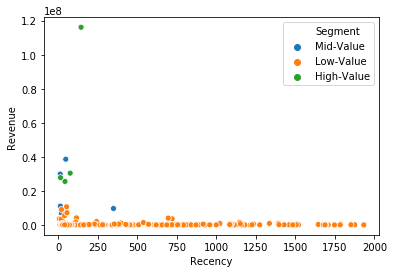

In [271]:
sns.scatterplot(x="Recency", y="Revenue", data=fs_cust, hue="Segment")

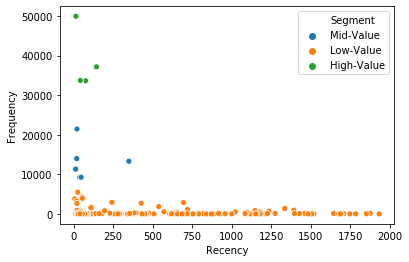

In [272]:
sns.scatterplot(x="Recency", y="Frequency", data=fs_cust, hue="Segment")

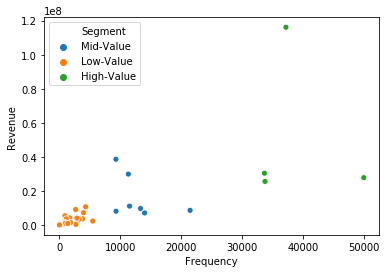

In [274]:
sns.scatterplot(x="Frequency", y="Revenue", data=fs_cust, hue="Segment")

In [276]:
fs_cust.groupby('Segment')['Segment'].describe()

count unique         top freq
Segment                                 
High-Value     4      1  High-Value    4
Low-Value    140      1   Low-Value  140
Mid-Value      7      1   Mid-Value    7

# High Value: Improve Retention
# Mid Value: Improve Retention + Increase Frequency
# Low Value: Increase Frequency


In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer.


In [540]:
# model build on 2014-2017
# predict 2017-2019

fs_calc = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)

print(len(fs_calc))
print(len(fs_next))

1023834
793911


In [541]:
#create fs_calc for assigning clustering
# same action as above just for training data set

fs_cust = pd.DataFrame(fs_calc['CustId'].unique())
fs_cust.columns = ['CustId']

#calculate recency score
fs_max_purchase = fs_calc.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_cust = pd.merge(fs_cust, fs_max_purchase[['CustId','Recency']], on='CustId')

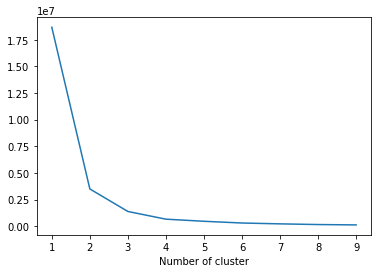

In [542]:
# criteria - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [543]:
n_clusters=3

In [544]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust['RecencyCluster'].value_counts()
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count        mean         std    min    25%    50%    75%  \
RecencyCluster                                                              
0                35.0  845.114286  149.025614  603.0  710.5  830.0  976.5   
1                39.0  349.128205  109.823586  192.0  258.0  323.0  413.0   
2                96.0   31.375000   42.111194    0.0    2.0   12.5   49.0   

                   max  
RecencyCluster          
0               1080.0  
1                571.0  
2                165.0

In [545]:
fs_max_purchase.sort_values(by=['Recency'], ascending =[False])

CustId MaxPurchaseDate  Recency
132  cust_id_4124      2014-01-15     1080
13   cust_id_1387      2014-01-20     1075
135  cust_id_4187      2014-01-27     1068
72   cust_id_2605      2014-02-05     1059
12   cust_id_1369      2014-03-18     1018
..            ...             ...      ...
33   cust_id_1845      2016-12-30        0
61   cust_id_2439      2016-12-30        0
90   cust_id_2984      2016-12-30        0
95   cust_id_3163      2016-12-30        0
22   cust_id_1610      2016-12-30        0

[170 rows x 3 columns]

In [546]:
len(fs_cust)

170

In [547]:
#calcuate frequency score
fs_frequency = fs_calc.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')

In [548]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)
fs_cust['FrequencyCluster'].value_counts()

0    144
1     23
2      3
Name: FrequencyCluster, dtype: int64

In [549]:
fs_cust_sort=fs_cust.sort_values(by=['Frequency'], ascending =[False])
fs_cust_sort.head(20)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
144   cust_id_876        3               2     120471                 2
145  cust_id_4279        3               2     108393                 2
146  cust_id_4201        9               2      66887                 2
155  cust_id_1700        1               2      43016                 1
163  cust_id_3163        0               2      39220                 1
168  cust_id_1422       18               2      38401                 1
147   cust_id_879        1               2      34794                 1
158  cust_id_4061        2               2      33713                 1
157  cust_id_1621        0               2      33038                 1
150  cust_id_2000        9               2      30319                 1
148  cust_id_1584        2               2      29907                 1
167   cust_id_178       11               2      29775                 1
154  cust_id_1845        0               2      29544                 1
161  cust_id_2582        1               2      28582                 1
166  cust_id_2630        7               2      26052                 1
153  cust_id_3408        2               2      24882                 1
152  cust_id_1130        1               2      21849                 1
162  cust_id_2462       17               2      21846                 1
156   cust_id_549        1               2      20128                 1
151  cust_id_2053        1               2      19786                 1

In [550]:
fs_cust_test=fs_cust
#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_576'].index, inplace=True)

# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_876'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_4279'].index, inplace=True)
#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_2585'].index, inplace=True)

In [551]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust_test[['Frequency']])
fs_cust_test['FrequencyCluster'] = kmeans.predict(fs_cust_test[['Frequency']])

fs_cust_test = order_cluster('FrequencyCluster', 'Frequency',fs_cust_test,True)
fs_cust_test['FrequencyCluster'].value_counts()

0    144
1     23
2      3
Name: FrequencyCluster, dtype: int64

In [552]:
# lets use without 576
#fs_cust=fs_cust_test

#calcuate revenue score
fs_calc['Revenue'] = fs_calc['SellPrice'] * fs_calc['Quantity']
fs_revenue = fs_calc.groupby('CustId').Revenue.sum().reset_index()
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     cust_id_535        0               2      10654                 0   
1    cust_id_2110        1               2       7318                 0   
2    cust_id_1848       50               2       2288                 0   
3     cust_id_325        2               2      10415                 0   
4     cust_id_276        8               2       3761                 0   
..            ...      ...             ...        ...               ...   
165  cust_id_2462       17               2      21846                 2   
166  cust_id_3163        0               2      39220                 2   
167  cust_id_2630        7               2      26052                 2   
168  cust_id_1422       18               2      38401                 2   
169  cust_id_1621        0               2      33038                 2   

          Revenue  RevenueCluster  
0    7.579433e+06               0  
1    6.488310e+06               0  
2    2.013588e+06               0  
3    1.086783e+07               0  
4    3.832066e+06               0  
..            ...             ...  
165  1.891067e+07               1  
166  3.028976e+07               1  
167  2.573306e+07               1  
168  1.494912e+07               1  
169  1.094220e+08               2  

[170 rows x 7 columns]

In [553]:
fs_cust_test.groupby('FrequencyCluster')['Frequency'].describe()

count          mean           std      min      25%  \
FrequencyCluster                                                        
0                 144.0    889.291667   2087.353947      1.0      5.0   
1                  23.0  26088.043478   8552.081950  13881.0  19173.5   
2                   3.0  98583.666667  28106.556696  66887.0  87640.0   

                       50%       75%       max  
FrequencyCluster                                
0                     59.0     493.0   10654.0  
1                  26052.0   31678.5   43016.0  
2                 108393.0  114432.0  120471.0

In [554]:
#overall scoring
fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>1,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>3,'Segment'] = 'High-Value' 

In [555]:
fs_cust['OverallScore'].value_counts()

2    70
1    39
0    35
5    15
4    10
6     1
Name: OverallScore, dtype: int64

In [556]:
fs_cust.groupby('Segment')['Segment'].describe()

count unique         top freq
Segment                                 
High-Value    26      1  High-Value   26
Low-Value     74      1   Low-Value   74
Mid-Value     70      1   Mid-Value   70

In [557]:
#calculate revenue and create a new dataframe for it from modeling years 2017-2019
fs_next['Revenue'] = fs_next['SellPrice'] * fs_next['Quantity']
fs_cust_next = fs_next.groupby('CustId')['Revenue'].sum().reset_index()
fs_cust_next.columns = ['CustId','next_Revenue']
fs_cust_next.head(5)

CustId  next_Revenue
0  cust_id_1028  3.177632e+06
1  cust_id_1031  2.207994e+03
2  cust_id_1051  3.683231e+05
3  cust_id_1066  2.935993e+04
4  cust_id_1103  1.345255e+06

In [558]:
fs_merge = pd.merge(fs_cust, fs_cust_next, on='CustId', how='left')
fs_merge = fs_merge.fillna(0)
fs_merge.head(10)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535        0               2      10654                 0   
1  cust_id_2110        1               2       7318                 0   
2  cust_id_1848       50               2       2288                 0   
3   cust_id_325        2               2      10415                 0   
4   cust_id_276        8               2       3761                 0   
5  cust_id_2439        0               2       9452                 0   
6  cust_id_3603       49               2       1090                 0   
7  cust_id_2935       21               2       8360                 0   
8   cust_id_228        2               2       3902                 0   
9  cust_id_2600        0               2        154                 0   

        Revenue  RevenueCluster  OverallScore    Segment  next_Revenue  
0  7.579433e+06               0             2  Mid-Value  2.069781e+06  
1  6.488310e+06               0             2  Mid-Value  5.150964e+06  
2  2.013588e+06               0             2  Mid-Value  3.760447e+06  
3  1.086783e+07               0             2  Mid-Value  6.132642e+06  
4  3.832066e+06               0             2  Mid-Value  2.076269e+06  
5  1.147869e+07               0             2  Mid-Value  1.206784e+07  
6  3.342220e+06               0             2  Mid-Value  2.498087e+05  
7  5.043094e+06               0             2  Mid-Value  1.097041e+06  
8  3.206619e+06               0             2  Mid-Value  7.443600e+06  
9  6.985316e+04               0             2  Mid-Value  1.153424e+05

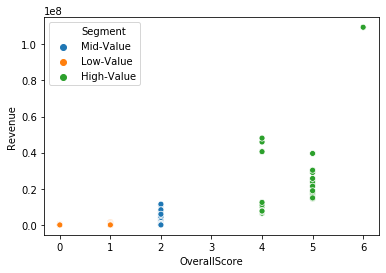

In [559]:
sns.scatterplot(x="OverallScore", y="Revenue", data=fs_merge, hue="Segment")

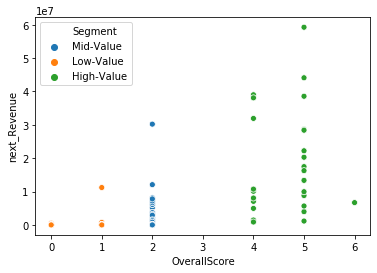

In [560]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_merge, hue="Segment")

In [561]:
fs_merge

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     cust_id_535        0               2      10654                 0   
1    cust_id_2110        1               2       7318                 0   
2    cust_id_1848       50               2       2288                 0   
3     cust_id_325        2               2      10415                 0   
4     cust_id_276        8               2       3761                 0   
..            ...      ...             ...        ...               ...   
165  cust_id_2462       17               2      21846                 2   
166  cust_id_3163        0               2      39220                 2   
167  cust_id_2630        7               2      26052                 2   
168  cust_id_1422       18               2      38401                 2   
169  cust_id_1621        0               2      33038                 2   

          Revenue  RevenueCluster  OverallScore     Segment  next_Revenue  
0    7.579433e+06               0             2   Mid-Value  2.069781e+06  
1    6.488310e+06               0             2   Mid-Value  5.150964e+06  
2    2.013588e+06               0             2   Mid-Value  3.760447e+06  
3    1.086783e+07               0             2   Mid-Value  6.132642e+06  
4    3.832066e+06               0             2   Mid-Value  2.076269e+06  
..            ...             ...           ...         ...           ...  
165  1.891067e+07               1             5  High-Value  5.925283e+07  
166  3.028976e+07               1             5  High-Value  4.411022e+07  
167  2.573306e+07               1             5  High-Value  3.856541e+07  
168  1.494912e+07               1             5  High-Value  5.672820e+06  
169  1.094220e+08               2             6  High-Value  6.689262e+06  

[170 rows x 10 columns]

In [562]:
#remove outliers
#fs_merge = fs_merge[fs_merge['next_Revenue']<fs_merge['next_Revenue'].quantile(0.95)]
# drop next revenue equal to 0
#fs_merge.drop(fs_merge.loc[fs_merge['next_Revenue']==0].index, inplace=True)

#creating 3 clusters of next revenue
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(fs_merge[['next_Revenue']])
fs_merge['LTVCluster'] = kmeans.predict(fs_merge[['next_Revenue']])

#order cluster number based on LTV
fs_merge = order_cluster('LTVCluster', 'next_Revenue',fs_merge,True)

#creatinga new cluster dataframe
fs_cluster = fs_merge.copy()

#see details of the clusters
fs_cluster.groupby('LTVCluster')['next_Revenue'].describe()

count          mean           std           min           25%  \
LTVCluster                                                                  
0           139.0  4.015265e+05  9.641908e+05  0.000000e+00  0.000000e+00   
1            22.0  1.042881e+07  4.737017e+06  5.672820e+06  7.098508e+06   
2             9.0  3.757653e+07  9.787450e+06  2.838667e+07  3.020897e+07   

                     50%           75%           max  
LTVCluster                                            
0           2.831993e+03  1.425950e+05  5.150964e+06  
1           8.455864e+06  1.185272e+07  2.222680e+07  
2           3.808717e+07  3.901095e+07  5.925283e+07

In [563]:
fs_cluster.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0   cust_id_535        0               2      10654                 0   
1  cust_id_2110        1               2       7318                 0   
2  cust_id_1848       50               2       2288                 0   
3   cust_id_276        8               2       3761                 0   
4  cust_id_3603       49               2       1090                 0   

        Revenue  RevenueCluster  OverallScore    Segment  next_Revenue  \
0  7.579433e+06               0             2  Mid-Value  2.069781e+06   
1  6.488310e+06               0             2  Mid-Value  5.150964e+06   
2  2.013588e+06               0             2  Mid-Value  3.760447e+06   
3  3.832066e+06               0             2  Mid-Value  2.076269e+06   
4  3.342220e+06               0             2  Mid-Value  2.498087e+05   

   LTVCluster  
0           0  
1           0  
2           0  
3           0  
4           0

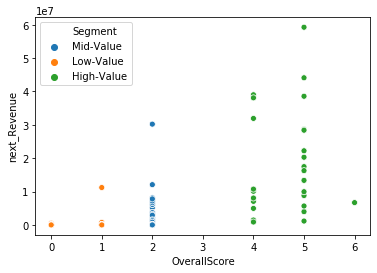

In [564]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_cluster, hue="Segment")

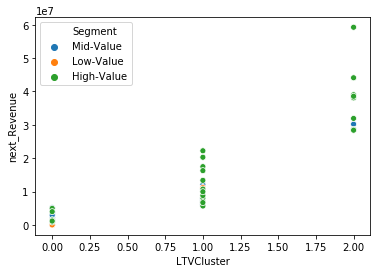

In [565]:
sns.scatterplot(x="LTVCluster", y="next_Revenue", data=fs_cluster, hue="Segment")

In [566]:
fs_cluster.groupby('LTVCluster')['LTVCluster'].describe()

count  mean  std  min  25%  50%  75%  max
LTVCluster                                           
0           139.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1            22.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2             9.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0

In [567]:
#convert categorical columns to numerical
fs_class = pd.get_dummies(fs_cluster)
fs_class_matrix=fs_cluster

#calculate and show correlations
corr_matrix = fs_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster             1.000000
next_Revenue           0.913819
Segment_High-Value     0.699506
Frequency              0.696953
RevenueCluster         0.689200
                         ...   
CustId_cust_id_178    -0.033855
CustId_cust_id_1845   -0.033855
Segment_Mid-Value     -0.144662
Recency               -0.348277
Segment_Low-Value     -0.364219
Name: LTVCluster, Length: 182, dtype: float64

In [568]:
len(fs_cluster)

170

In [569]:
#create X and y, X will be feature set and y is the label - LTV
X = fs_class.drop(['LTVCluster','next_Revenue'],axis=1)
y = fs_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [570]:
print(X_train.shape,y_train.shape)
print(y_train.value_counts())

(136, 180) (136,)
0    111
1     18
2      7
Name: LTVCluster, dtype: int64


In [571]:
smote=SMOTE('minority')

xsm,ysm=smote.fit_sample(X_train,y_train)
print(xsm.shape,ysm.shape)

(240, 180) (240,)


In [572]:
print(X_test.shape,y_test.shape)
#print(ysm.value_counts())
uniqueValues, occurCount = np.unique(ysm, return_counts=True)
print(uniqueValues,occurCount)

(34, 180) (34,)
[0 1 2] [111  18 111]


In [573]:
xsm1,ysm1=smote.fit_sample(xsm,ysm)
print(xsm1.shape,ysm1.shape)

(333, 180) (333,)


In [574]:
# XGBoost Multiclassification Model

ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.96
Accuracy of XGB classifier on test set: 0.91
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.67      1.00      0.80         4
           2       0.50      0.50      0.50         2

    accuracy                           0.91        34
   macro avg       0.72      0.81      0.75        34
weighted avg       0.93      0.91      0.92        34



In [575]:
X_test=X_test.as_matrix()
y_test=y_test.as_matrix()

In [576]:
# XGBoost Multiclassification Model

ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(xsm1, ysm1)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(xsm1, ysm1)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.98
Accuracy of XGB classifier on test set: 0.94
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.67      1.00      0.80         4
           2       1.00      1.00      1.00         2

    accuracy                           0.94        34
   macro avg       0.89      0.98      0.92        34
weighted avg       0.96      0.94      0.95        34



In [577]:
# XGBoost Multiclassification Model
# Predict next revenue

ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(xsm, ysm)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(xsm, ysm)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.98
Accuracy of XGB classifier on test set: 0.94
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       1.00      0.75      0.86         4
           2       0.50      1.00      0.67         2

    accuracy                           0.94        34
   macro avg       0.83      0.90      0.84        34
weighted avg       0.97      0.94      0.95        34



In [578]:
#Predict next purchase

In [579]:
fs_prev = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)
fs_user = pd.DataFrame(fs_prev['CustId'].unique())
fs_user.columns = ['CustId']
fs_user.head(10)

CustId
0   cust_id_535
1   cust_id_876
2   cust_id_879
3  cust_id_4279
4  cust_id_1584
5  cust_id_2768
6  cust_id_2000
7  cust_id_2110
8  cust_id_2053
9  cust_id_1130

In [580]:
#create a dataframe with customer id and first purchase date in fs_next
fs_next_first_purchase = fs_next.groupby('CustId').Date.min().reset_index()
fs_next_first_purchase.columns = ['CustId','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in fs_next
fs_last_purchase = fs_prev.groupby('CustId').Date.max().reset_index()
fs_last_purchase.columns = ['CustId','MaxPurchaseDate']

#merge two dataframes
fs_purchase_dates = pd.merge(fs_last_purchase,fs_next_first_purchase,on='CustId',how='left')

#calculate the time difference in days:
fs_purchase_dates['NextPurchaseDay'] = (fs_purchase_dates['MinPurchaseDate'] - fs_purchase_dates['MaxPurchaseDate']).dt.days

#merge with fs_user 
fs_user = pd.merge(fs_user, fs_purchase_dates[['CustId','NextPurchaseDay']],on='CustId',how='left')

#print fs_user
fs_user.head()

#fill NA values with 999, meaning only one purchase in prev dataset
fs_user = fs_user.fillna(999)
fs_user.head(10)
len(fs_user)

170

In [581]:
#create a dataframe with CustomerID and Invoice Date
fs_day_order = fs_prev[['CustId','Date']]
#convert Invoice Datetime to day
fs_day_order['InvoiceDay'] = fs_prev['Date'].dt.date
fs_day_order = fs_day_order.sort_values(['CustId','Date'])
len(fs_day_order)

1023834

In [582]:
#drop duplicates
fs_day_order = fs_day_order.drop_duplicates(subset=['CustId','InvoiceDay'],keep='first')
fs_day_order.head(10)
len(fs_day_order)

13694

In [583]:
#shifting last 3 purchase dates
fs_day_order['PrevInvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(1)
fs_day_order['T2InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(2)
fs_day_order['T3InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(3)

In [584]:
# find differences between purchases
fs_day_order['DayDiff'] = (fs_day_order['InvoiceDay'] - fs_day_order['PrevInvoiceDate']).dt.days
fs_day_order['DayDiff2'] = (fs_day_order['InvoiceDay'] - fs_day_order['T2InvoiceDate']).dt.days
fs_day_order['DayDiff3'] = (fs_day_order['InvoiceDay'] - fs_day_order['T3InvoiceDate']).dt.days

In [585]:
# find mean and std
fs_day_diff = fs_day_order.groupby('CustId').agg({'DayDiff': ['mean','std']}).reset_index()
fs_day_diff.columns = ['CustId', 'DayDiffMean','DayDiffStd']
fs_day_diff
len(fs_day_diff)

170

In [586]:
fs_day_order_last = fs_day_order.drop_duplicates(subset=['CustId'],keep='last')
fs_day_order_last = fs_day_order_last.dropna()
fs_day_order_last.head(10)

CustId       Date  InvoiceDay PrevInvoiceDate T2InvoiceDate  \
873026   cust_id_1028 2016-12-15  2016-12-15      2016-11-29    2016-10-14   
523251   cust_id_1066 2016-06-06  2016-06-06      2016-04-19    2016-04-04   
399686   cust_id_1130 2016-12-29  2016-12-29      2016-12-21    2016-12-16   
854555   cust_id_1203 2016-12-14  2016-12-14      2016-12-01    2016-11-23   
1018350  cust_id_1276 2016-04-07  2016-04-07      2016-02-02    2015-10-28   
969972   cust_id_1422 2016-12-12  2016-12-12      2016-12-08    2016-12-06   
1007961  cust_id_1508 2016-11-17  2016-11-17      2016-07-11    2016-07-01   
1013639   cust_id_153 2016-11-30  2016-11-30      2016-10-27    2016-10-06   
304191   cust_id_1584 2016-12-28  2016-12-28      2016-12-27    2016-12-23   
833798   cust_id_1586 2016-12-30  2016-12-30      2016-12-15    2016-12-14   

        T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  
873026     2016-10-10     16.0      62.0      66.0  
523251     2016-02-27     48.0      63.0     100.0  
399686     2016-12-08      8.0      13.0      21.0  
854555     2016-11-21     13.0      21.0      23.0  
1018350    2015-05-06     65.0     162.0     337.0  
969972     2016-12-03      4.0       6.0       9.0  
1007961    2016-04-25    129.0     139.0     206.0  
1013639    2016-09-02     34.0      55.0      89.0  
304191     2016-12-22      1.0       5.0       6.0  
833798     2016-12-08     15.0      16.0      22.0

In [587]:
fs_day_order_last = pd.merge(fs_day_order_last, fs_day_diff, on='CustId')
fs_day_order_last.head(10)

CustId       Date  InvoiceDay PrevInvoiceDate T2InvoiceDate  \
0  cust_id_1028 2016-12-15  2016-12-15      2016-11-29    2016-10-14   
1  cust_id_1066 2016-06-06  2016-06-06      2016-04-19    2016-04-04   
2  cust_id_1130 2016-12-29  2016-12-29      2016-12-21    2016-12-16   
3  cust_id_1203 2016-12-14  2016-12-14      2016-12-01    2016-11-23   
4  cust_id_1276 2016-04-07  2016-04-07      2016-02-02    2015-10-28   
5  cust_id_1422 2016-12-12  2016-12-12      2016-12-08    2016-12-06   
6  cust_id_1508 2016-11-17  2016-11-17      2016-07-11    2016-07-01   
7   cust_id_153 2016-11-30  2016-11-30      2016-10-27    2016-10-06   
8  cust_id_1584 2016-12-28  2016-12-28      2016-12-27    2016-12-23   
9  cust_id_1586 2016-12-30  2016-12-30      2016-12-15    2016-12-14   

  T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0    2016-10-10     16.0      62.0      66.0    13.278481   11.528045  
1    2016-02-27     48.0      63.0     100.0    24.611111   29.733365  
2    2016-12-08      8.0      13.0      21.0     3.886121    3.116979  
3    2016-11-21     13.0      21.0      23.0    11.393617   11.080563  
4    2015-05-06     65.0     162.0     337.0   112.333333   56.580326  
5    2016-12-03      4.0       6.0       9.0     4.819820    3.619200  
6    2016-04-25    129.0     139.0     206.0    28.861111   49.053995  
7    2016-09-02     34.0      55.0      89.0    36.481481   30.113082  
8    2016-12-22      1.0       5.0       6.0     2.549065    1.743485  
9    2016-12-08     15.0      16.0      22.0     5.717277    7.605653

In [588]:
fs_cust = pd.merge(fs_user, fs_cust, on='CustId')
fs_cust.head(10)

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0   cust_id_535              6.0        0               2      10654   
1   cust_id_876              7.0        3               2     120471   
2   cust_id_879              6.0        1               2      34794   
3  cust_id_4279              8.0        3               2     108393   
4  cust_id_1584              6.0        2               2      29907   
5  cust_id_2768              6.0        0               2      16317   
6  cust_id_2000             13.0        9               2      30319   
7  cust_id_2110             15.0        1               2       7318   
8  cust_id_2053              5.0        1               2      19786   
9  cust_id_1130              8.0        1               2      21849   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  
0                 0  7.579433e+06               0             2   Mid-Value  
1                 1  4.592764e+07               1             4  High-Value  
2                 2  2.902659e+07               1             5  High-Value  
3                 1  4.804609e+07               1             4  High-Value  
4                 2  2.141297e+07               1             5  High-Value  
5                 2  1.450973e+07               1             5  High-Value  
6                 2  3.955657e+07               1             5  High-Value  
7                 0  6.488310e+06               0             2   Mid-Value  
8                 2  1.703963e+07               1             5  High-Value  
9                 2  1.015234e+07               0             4  High-Value

In [589]:
fs_user2 = pd.merge(fs_cust, fs_day_order_last[['CustId','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustId')
#create fs_class as a copy of fs_user before applying get_dummies
fs_user2.head(10)

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0   cust_id_535              6.0        0               2      10654   
1   cust_id_876              7.0        3               2     120471   
2   cust_id_879              6.0        1               2      34794   
3  cust_id_4279              8.0        3               2     108393   
4  cust_id_1584              6.0        2               2      29907   
5  cust_id_2768              6.0        0               2      16317   
6  cust_id_2000             13.0        9               2      30319   
7  cust_id_2110             15.0        1               2       7318   
8  cust_id_2053              5.0        1               2      19786   
9  cust_id_1130              8.0        1               2      21849   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  \
0                 0  7.579433e+06               0             2   Mid-Value   
1                 1  4.592764e+07               1             4  High-Value   
2                 2  2.902659e+07               1             5  High-Value   
3                 1  4.804609e+07               1             4  High-Value   
4                 2  2.141297e+07               1             5  High-Value   
5                 2  1.450973e+07               1             5  High-Value   
6                 2  3.955657e+07               1             5  High-Value   
7                 0  6.488310e+06               0             2   Mid-Value   
8                 2  1.703963e+07               1             5  High-Value   
9                 2  1.015234e+07               0             4  High-Value   

   DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0      2.0       8.0      11.0     5.844920    5.899017  
1      1.0       6.0       8.0     2.233607    1.571936  
2      2.0       7.0       8.0     2.723192    2.130888  
3      5.0       6.0       7.0     1.656535    1.225290  
4      1.0       5.0       6.0     2.549065    1.743485  
5      1.0       2.0       9.0     2.547786    1.982559  
6      5.0       7.0      12.0     4.839286    3.287573  
7     14.0      15.0      20.0     2.858639    2.287916  
8      1.0       6.0       7.0     1.841484    1.291278  
9      8.0      13.0      21.0     3.886121    3.116979

In [590]:
fs_class = fs_user2.copy()
fs_class = pd.get_dummies(fs_class)
fs_class.head(10)

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0              6.0        0               2      10654                 0   
1              7.0        3               2     120471                 1   
2              6.0        1               2      34794                 2   
3              8.0        3               2     108393                 1   
4              6.0        2               2      29907                 2   
5              6.0        0               2      16317                 2   
6             13.0        9               2      30319                 2   
7             15.0        1               2       7318                 0   
8              5.0        1               2      19786                 2   
9              8.0        1               2      21849                 2   

        Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
0  7.579433e+06               0             2      2.0       8.0  ...   
1  4.592764e+07               1             4      1.0       6.0  ...   
2  2.902659e+07               1             5      2.0       7.0  ...   
3  4.804609e+07               1             4      5.0       6.0  ...   
4  2.141297e+07               1             5      1.0       5.0  ...   
5  1.450973e+07               1             5      1.0       2.0  ...   
6  3.955657e+07               1             5      5.0       7.0  ...   
7  6.488310e+06               0             2     14.0      15.0  ...   
8  1.703963e+07               1             5      1.0       6.0  ...   
9  1.015234e+07               0             4      8.0      13.0  ...   

   CustId_cust_id_817  CustId_cust_id_832  CustId_cust_id_876  \
0                   0                   0                   0   
1                   0                   0                   1   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   0                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   0                   0   

   CustId_cust_id_879  CustId_cust_id_935  CustId_cust_id_959  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   1                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   
5                   0                   0                   0   
6                   0                   0                   0   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   0                   0   

   CustId_cust_id_992  Segment_High-Value  Segment_Low-Value  \
0                   0                   0                  0   
1                   0                   1                  0   
2                   0                   1                  0   
3                   0                   1                  0   
4                   0                   1                  0   
5                   0                   1                  0   
6                   0                   1                  0   
7                   0                   0                  0   
8                   0                   1                  0   
9                   0                   1                  0   

   Segment_Mid-Value  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
6                  0  
7                  1  
8                 

In [603]:
fs_class=fs_class.sort_values(by=['NextPurchaseDay'], ascending =[False])
fs_class

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
83           1043.0      694               0         12                 0   
84            999.0      655               0        217                 0   
95            999.0      238               1        409                 0   
90            999.0      535               1        947                 0   
93            999.0      478               1       1380                 0   
..              ...      ...             ...        ...               ...   
41              5.0        1               2       2927                 0   
34              5.0        0               2      13881                 2   
33              4.0        0               2      39220                 2   
19              4.0        1               2      20128                 2   
26              4.0        0               2      15504                 2   

         Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
83  6.549984e+04               0             0     37.0      51.0  ...   
84  5.523466e+05               0             0     27.0      31.0  ...   
95  4.940841e+05               0             1    529.0     570.0  ...   
90  9.042924e+05               0             1     19.0     267.0  ...   
93  8.767018e+05               0             1      7.0       9.0  ...   
..           ...             ...           ...      ...       ...  ...   
41  3.945222e+06               0             2      1.0      20.0  ...   
34  6.486532e+06               0             4     15.0      16.0  ...   
33  3.028976e+07               1             5      2.0       3.0  ...   
19  1.819181e+07               1             5      1.0       9.0  ...   
26  1.119850e+07               0             4      1.0       3.0  ...   

    CustId_cust_id_832  CustId_cust_id_876  CustId_cust_id_879  \
83                   0                   0                   0   
84                   0                   0                   0   
95                   0                   0                   0   
90                   0                   0                   0   
93                   0                   0                   0   
..                 ...                 ...                 ...   
41                   0                   0                   0   
34                   0                   0                   0   
33                   0                   0                   0   
19                   0                   0                   0   
26                   0                   0                   0   

    CustId_cust_id_935  CustId_cust_id_959  CustId_cust_id_992  \
83                   0                   0                   0   
84                   0                   0                   0   
95                   0                   0                   0   
90                   0                   0                   0   
93                   0                   0                   0   
..                 ...                 ...                 ...   
41                   0                   0                   0   
34                   0                   0                   0   
33                   0                   0                   0   
19                   0                   0                   0   
26                   0                   0                   0   

    Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  \
83                   0                  1                  0   
84                   0                  1                  0   
95                   0                  1                  0   
90                   0                  1                  0   
93                   0                  1                  0   
..                 ...                ...                ...   
41                   0                  0                  1   
34                   1                  0                  0   
33                   1      

In [604]:
# delete 999, meaning 1 purchase

fs_class.drop(fs_class.loc[fs_class['NextPurchaseDay']==999].index, inplace=True)

In [605]:
fs_class['NextPurchaseDayRange'] = 2
fs_class.loc[fs_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 1
fs_class.loc[fs_class.NextPurchaseDay>200,'NextPurchaseDayRange'] = 0

In [606]:
fs_class.groupby('NextPurchaseDayRange')['NextPurchaseDay'].describe()

count        mean         std    min    25%    50%  \
NextPurchaseDayRange                                                       
0                      11.0  458.636364  312.182406  218.0  228.0  262.0   
1                      21.0   96.809524   34.152041   53.0   69.0   93.0   
2                      49.0   13.224490    9.870548    4.0    6.0    9.0   

                        75%     max  
NextPurchaseDayRange                 
0                     699.5  1043.0  
1                     124.0   179.0  
2                      18.0    48.0

In [607]:
#train & test split

#fs_class = fs_class.drop('NextPurchaseDay',axis=1)

X, y = fs_class.drop('NextPurchaseDayRange',axis=1), fs_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.84615385 0.53846154 0.69230769 0.76923077 0.66666667]
NB [0.76923077 0.46153846 0.76923077 0.61538462 0.83333333]
RF [0.84615385 0.92307692 0.84615385 0.92307692 0.75      ]
SVC [0.76923077 0.53846154 0.61538462 0.76923077 0.5       ]
Dtree [1.         1.         1.         0.84615385 1.        ]
XGB [1.         1.         1.         0.84615385 1.        ]
KNN [0.69230769 0.38461538 0.76923077 0.69230769 0.58333333]


In [608]:
fs_class

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
83           1043.0      694               0         12                 0   
62            876.0      624               0        100                 0   
94            795.0      207               1         21                 0   
88            604.0       31               2        236                 0   
68            334.0      307               1       1775                 0   
..              ...      ...             ...        ...               ...   
41              5.0        1               2       2927                 0   
34              5.0        0               2      13881                 2   
33              4.0        0               2      39220                 2   
19              4.0        1               2      20128                 2   
26              4.0        0               2      15504                 2   

         Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
83  6.549984e+04               0             0     37.0      51.0  ...   
62  1.399717e+05               0             0     70.0      83.0  ...   
94  9.103977e+03               0             1     12.0     278.0  ...   
88  5.191520e+05               0             2    533.0     536.0  ...   
68  1.340777e+06               0             1     73.0      79.0  ...   
..           ...             ...           ...      ...       ...  ...   
41  3.945222e+06               0             2      1.0      20.0  ...   
34  6.486532e+06               0             4     15.0      16.0  ...   
33  3.028976e+07               1             5      2.0       3.0  ...   
19  1.819181e+07               1             5      1.0       9.0  ...   
26  1.119850e+07               0             4      1.0       3.0  ...   

    CustId_cust_id_832  CustId_cust_id_876  CustId_cust_id_879  \
83                   0                   0                   0   
62                   0                   0                   0   
94                   0                   0                   0   
88                   0                   0                   0   
68                   0                   0                   0   
..                 ...                 ...                 ...   
41                   0                   0                   0   
34                   0                   0                   0   
33                   0                   0                   0   
19                   0                   0                   0   
26                   0                   0                   0   

    CustId_cust_id_935  CustId_cust_id_959  CustId_cust_id_992  \
83                   0                   0                   0   
62                   0                   0                   0   
94                   0                   0                   0   
88                   0                   0                   0   
68                   0                   0                   0   
..                 ...                 ...                 ...   
41                   0                   0                   0   
34                   0                   0                   0   
33                   0                   0                   0   
19                   0                   0                   0   
26                   0                   0                   0   

    Segment_High-Value  Segment_Low-Value  Segment_Mid-Value  \
83                   0                  1                  0   
62                   0                  1                  0   
94                   0                  1                  0   
88                   0                  0                  1   
68                   0                  1                  0   
..                 ...                ...                ...   
41                   0                  0                  1   
34                   1                  0                  0   
33                   1      

In [ ]:
### Churn

In [671]:
#converting the type of Invoice Date Field from string to datetime.
sales=sales_copy
sales['Date'] = pd.to_datetime(sales['Date'])

cust_group = sales.groupby(['CustId','Date'])['SellPrice'].sum().reset_index()

In [672]:
list(sales.columns) 

['Date',
 'OrderNumber',
 'OrderLineNumber',
 'Quantity',
 'SellPrice',
 'CCN',
 'PartnerNumber',
 'Material',
 'ItemCategoryGroup',
 'ItemCategory',
 'ItemDescription',
 'ProductCode',
 'ProductDescription',
 'NounCodeDescription',
 'NounCode',
 'ShipFrom',
 'CustomerName',
 'CustId',
 'City',
 'State',
 'PostalCode',
 'Country',
 'Region',
 'SubRegion',
 'Industry',
 'IndustryGroup',
 'Plant',
 'PlantType',
 'PlantPlatform',
 'Market']

In [673]:
frequency = cust_group.groupby('CustId').Date.count().reset_index()
frequency.columns = ['CustId','frequency']
max_purchase = cust_group.groupby('CustId').Date.max().reset_index()
min_purchase = cust_group.groupby('CustId').Date.min().reset_index()
max_purchase.columns = ['CustId','max_purchase']
min_purchase.columns = ['CustId','min_purchase']

In [674]:
len(frequency)

230

In [714]:
fs = pd.merge(frequency,min_purchase,on='CustId',how='left')
fs = pd.merge(fs,max_purchase,on='CustId',how='left')
fs['Period'] = ((fs['max_purchase'] - fs['min_purchase']).dt.days)/30
fs

CustId  frequency min_purchase max_purchase     Period
0    cust_id_1028        149   2014-01-31   2019-05-07  64.066667
1    cust_id_1031          1   2018-07-20   2018-07-20   0.000000
2    cust_id_1033          1   2016-01-29   2016-01-29   0.000000
3    cust_id_1051         20   2017-06-21   2017-10-12   3.766667
4    cust_id_1066         58   2014-01-02   2019-04-24  64.600000
..            ...        ...          ...          ...        ...
225   cust_id_935         15   2014-12-30   2019-04-25  52.566667
226   cust_id_958          1   2014-03-28   2014-03-28   0.000000
227   cust_id_959        173   2014-01-08   2019-05-06  64.800000
228   cust_id_988          3   2016-09-27   2016-11-01   1.166667
229   cust_id_992         14   2014-01-21   2016-02-13  25.100000

[230 rows x 5 columns]

In [715]:
# remove one time purchaces
fs=fs.loc[fs['frequency'] > 1]

In [716]:
#daily rate
fs['rate'] = fs['frequency']/fs['Period']
fs.loc[~np.isfinite(fs['rate']), 'rate'] = np.nan
fs

CustId  frequency min_purchase max_purchase     Period      rate
0    cust_id_1028        149   2014-01-31   2019-05-07  64.066667  2.325702
3    cust_id_1051         20   2017-06-21   2017-10-12   3.766667  5.309735
4    cust_id_1066         58   2014-01-02   2019-04-24  64.600000  0.897833
5    cust_id_1103         86   2017-10-09   2019-05-06  19.133333  4.494774
6    cust_id_1113         17   2019-03-06   2019-05-07   2.066667  8.225806
..            ...        ...          ...          ...        ...       ...
224   cust_id_904          4   2014-02-11   2017-01-24  35.933333  0.111317
225   cust_id_935         15   2014-12-30   2019-04-25  52.566667  0.285352
227   cust_id_959        173   2014-01-08   2019-05-06  64.800000  2.669753
228   cust_id_988          3   2016-09-27   2016-11-01   1.166667  2.571429
229   cust_id_992         14   2014-01-21   2016-02-13  25.100000  0.557769

[177 rows x 6 columns]

In [717]:
fs.describe()

frequency      Period        rate
count   177.000000  177.000000  177.000000
mean    140.864407   35.901130    3.308286
std     247.186840   24.617191    4.228901
min       2.000000    0.133333    0.039683
25%       4.000000   11.666667    0.323974
50%      17.000000   37.500000    1.386555
75%     138.000000   63.500000    5.107692
max    1182.000000   65.033333   18.175295

In [718]:
ave=fs["rate"].mean()
fs['observed'] = np.where(fs['rate']>=ave, '0', '1')
# 0 no death yet

In [719]:
df=fs[['CustId', 'observed' , 'Period']]

In [720]:
#merge first purchase date column to our main dataframe

#Don't think we need to merge with original data set

sales_copy1 = pd.merge(sales, df, on='CustId')
sales_copy1.head(10)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   
5 2014-01-02  order_number_105429              180         2    41.33323   
6 2014-01-02  order_number_105429              180         1   217.33279   
7 2014-01-02  order_number_105429              180         2     7.99998   
8 2014-01-02  order_number_105429              180         1    42.66656   
9 2014-01-02  order_number_105429              180         1  1454.66303   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
5  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
6  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
7  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
8  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
9  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ... Region  SubRegion                       Industry IndustryGroup  \
0  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
1  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
2  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
3  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
4  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
5  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
6  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
7  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
8  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
9  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   

        Plant   PlantType     PlantPlatform            Market observed  \
0  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
1  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
2  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
3  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
4  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
5  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
6  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
7  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
8  Chesapeake  Unassigned  plant_platform_1  General Industry        0   
9  Chesapeake  Unassigned  plant_platform_1  General Industry        0   

      Period  
0  53.366667  
1  53.366667  
2  53.366667  
3  53.366667  
4  53.366667  
5  53.366667  
6  53.366667  
7  53.366667  
8  53.366667  
9  53.366667  

[10 rows x 32 columns]

In [721]:
from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()

In [722]:
T=fs["Period"]
C=fs["observed"]

Populating the interactive namespace from numpy and matplotlib


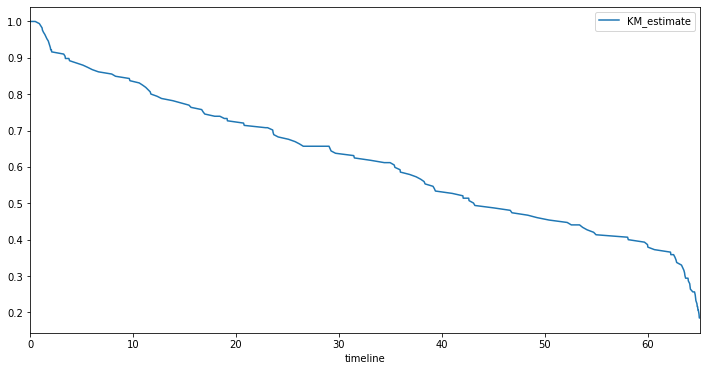

In [723]:
kmf.fit(T,C)
%pylab inline
figsize(12,6)
kmf.plot
kmf.survival_function_.plot()

In [724]:
fs_types = fs['CustId'].unique()
len(fs_types)

177

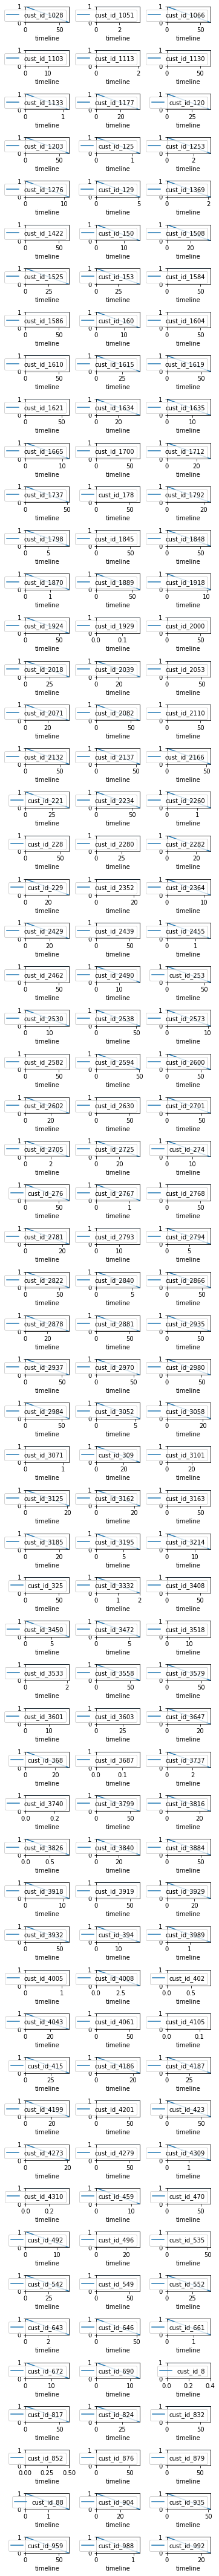

In [733]:
fs_types = fs['CustId'].unique()
fs_types
ii=0
plt.figure(figsize=(5,100))
for i in fs['CustId'].unique():
    ax = plt.subplot(100, 3, ii + 1)
    jj=fs['CustId']==i
    kmf.fit(T[jj],C[jj],label=i)
    ax=kmf.survival_function_.plot(ax=ax)
    ii=ii+1
    plt.ylim(0, 1);
plt.tight_layout() 